In [2]:
from src.python.deepseq0 import *

/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/site-packages/Bio/SearchIO/__init__.py:211: BiopythonExperimentalWarning: Bio.SearchIO is an experimental submodule which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning)
/home/yotamfr/development/prot2vec/virtualenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
from keras.models import model_from_json

from src.python import baselines
baselines.init_GO(asp=ASPECT)

ASPECT = 'F'  # Molecular Function

client = MongoClient("mongodb://localhost:27017/")

db = client['prot2vec']

print("Loading Ontology...")
onto = get_ontology(ASPECT)

model_str_deeperseq = "deeperseq-19-0.00224-0.57"
model_str_inception = "inception-14-0.00269-0.51"

# classes = [c for c in np.load('../../checkpoints/%s.npy' % model_str)]
classes = onto.classes
classes.remove(onto.root)
assert onto.root not in classes

with open('../../checkpoints/%s.json' % model_str_deeperseq, 'r') as f:
    deeperseq = model_from_json(f.read())
    
with open('../../checkpoints/%s.json' % model_str_inception, 'r') as f:
    inception = model_from_json(f.read())


Loading Ontology...
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
inception.load_weights("../../checkpoints/%s.hdf5" % model_str_inception)
print("Loaded model from disk")

deeperseq.load_weights("../../checkpoints/%s.hdf5" % model_str_deeperseq)
print("Loaded model from disk")

Loaded model from disk
Loaded model from disk


In [4]:
lim = None
trn_stream, tst_stream = get_training_and_validation_streams(db, onto, classes, limit=lim)

100%
Finished loading 81702 mappings!
100%
Finished loading 9049 mappings!


In [5]:
y_true, y_deeperseq = predict(deeperseq, batch_generator(tst_stream), len(tst_stream), classes)

Predicting...:  97%|█████████▋| 6355/6525 [12:05<00:18,  9.11it/s]


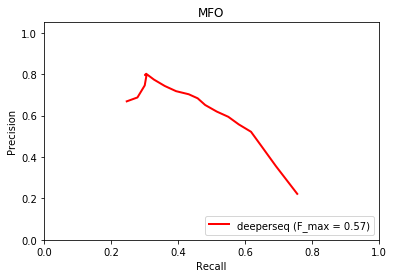

In [6]:
perf_deeperseq = baselines.performance(y_deeperseq, y_true, classes)
baselines.plot_precision_recall({"deeperseq": perf_deeperseq})

In [1]:
import pandas as pd
prs, rcs, f1s = perf_deeperseq
pd.DataFrame({"precision": prs, "recall": rcs, "F_max": f1s}).head(20)

NameError: name 'perf_deeperseq' is not defined

In [8]:
lim = None
trn_stream, tst_stream = get_training_and_validation_streams(db, onto, classes, limit=lim)

100%
Finished loading 81702 mappings!
100%
Finished loading 9049 mappings!


In [9]:
y_true, y_inception = predict(inception, batch_generator(tst_stream), len(tst_stream), classes)

Predicting...:  97%|█████████▋| 6355/6525 [02:38<00:04, 41.78it/s]


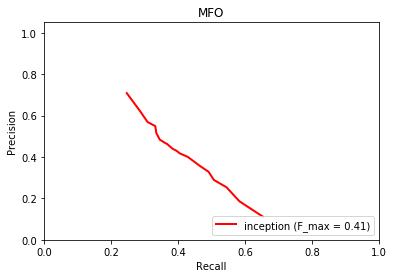

In [10]:
perf_inception = baselines.performance(y_inception, y_true, classes)
baselines.plot_precision_recall({"inception": perf_inception})

In [11]:
import pandas as pd
prs, rcs, f1s = perf_inception
pd.DataFrame({"precision": prs, "recall": rcs, "F_max": f1s}).head(10)

,F_max,precision,recall
0,0.189652,0.110897,0.654331
1,0.281893,0.185830,0.583557
2,0.345911,0.253336,0.545107
3,0.368412,0.289332,0.506982
4,0.393576,0.328197,0.491483
5,0.403175,0.354504,0.467339
6,0.410842,0.381756,0.444724
7,0.414303,0.400833,0.428710
8,0.411240,0.417713,0.404964
9,0.412047,0.429774,0.395725


In [9]:
def unpad_seq(padded_seq):
    return ''.join([AA.index2aa[ix] for ix in padded_seq if ix != PAD])

_, tst_stream = get_training_and_validation_streams(db, onto, classes, limit=lim)
seqs_valid = {k: unpad_seq(seq) for k, seq, _ in tst_stream}
annots_valid = tst_stream._seq2go

trn_stream, _ = get_training_and_validation_streams(db, onto, classes, limit=None)
seqs_train = {k: unpad_seq(seq) for k, seq, _ in trn_stream}
annots_train = trn_stream._seq2go

100%
Finished loading 81702 mappings!
100%
Finished loading 9049 mappings!
100%
Finished loading 81702 mappings!
100%
Finished loading 9049 mappings!


targets processed: 100%|██████████| 6355/6355 [00:00<00:00, 106039.81it/s]


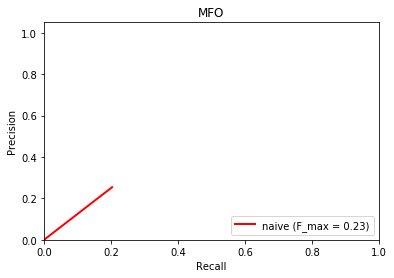

In [13]:
y_naive = baselines.predict(seqs_train, annots_train, seqs_valid, "naive", load_file=0)
perf_naive = baselines.performance(y_naive, annots_valid)
baselines.plot_precision_recall({"naive": perf_naive})

In [18]:
import pandas as pd
prs, rcs, f1s = perf_naive
pd.DataFrame({"precision": prs, "recall": rcs, "F_max": f1s}).head(20)

,F_max,precision,recall
0,0.225797,0.253973,0.203248
1,0.225797,0.253973,0.203248
2,0.225797,0.253973,0.203248
3,0.225797,0.253973,0.203248
4,0.225797,0.253973,0.203248
5,0.225797,0.253973,0.203248
6,NaN,0.000000,0.000000
7,NaN,0.000000,0.000000
8,NaN,0.000000,0.000000
9,NaN,0.000000,0.000000


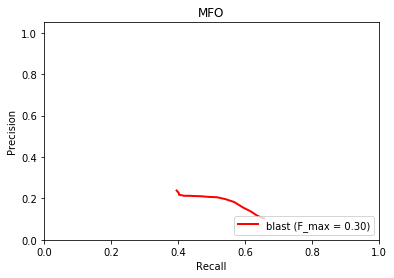

In [11]:
y_blast = baselines.predict(seqs_train, annots_train, seqs_valid, "blast", load_file=1)
perf_blast = baselines.performance(y_blast, annots_valid)
baselines.plot_precision_recall({"blast": perf_blast})

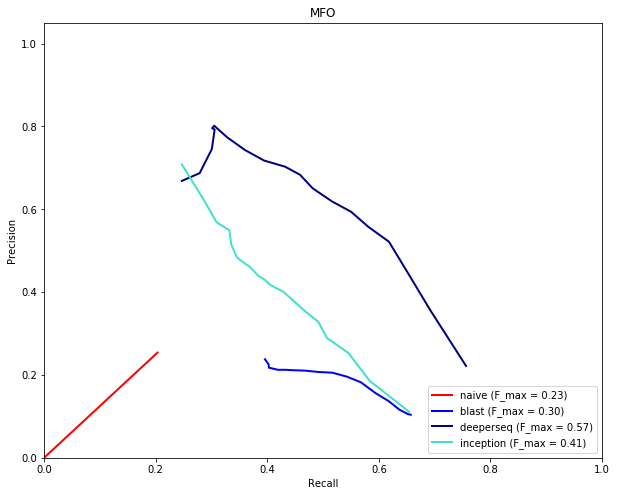

In [16]:
%matplotlib inline  
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

perf = {"naive": perf_naive, "blast": perf_blast, "deeperseq": perf_deeperseq, "inception": perf_inception}
baselines.plot_precision_recall(perf)

In [ ]:
s1 = reduce(lambda x, y: set(x) | set(y), trn_stream._seq2go.values(), set())
s2 = reduce(lambda x, y: set(x) | set(y), tst_stream._seq2go.values(), set())

len(s1), len(s2), len(s1 | s2), len(s1 & s2), len(s1 - s2), len(s2 - s1)